## Applying to cVax Dataset

In [1]:
### LIBRARY ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand

from mm_temptations_functions import *
from scipy.optimize import minimize, Bounds, LinearConstraint

from multiprocess import Pool
from functools import partial
import statsmodels.api as sm

import pickle

In [2]:
planting(456)

#### *Load Data*

In [3]:
filename = "csrDatasets/cVaxData_formatted_allTime_allDonor.pkl"
with open(filename, 'rb') as f:
    (pi_hat_donors, T_donors, k, u_donors, Q_template) = pickle.load(f)
    
isotype_list = ['IgM', 'IgG3', 'IgG1', 'IgA1', 'IgG2', 'IgG4', 'IgA2']

In [4]:
# set system wide param
k = 7
xterm = 1e-15
gterm = 1e-15
max_iter = 1e4
numCores = 5
theta_initial_ub = 4
mc_iter = 25

n_param = int(k/2 * (k-1))

reg_bounds = def_bounds(n_param, k, account_ingress=False)
reg_con = def_constraints(n_param, k)

Q_template = make_theta0(k,'Q')

optimiserArgs = {'costFunc': calc_cost_donors, 'args': (pi_hat_donors, T_donors, k, u_donors, Q_template), 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': theta_initial_ub}
options = {'hessian': None, 'xterm': xterm, 'gterm': gterm, 'max_iter': max_iter}

In [5]:
#theta_allP, optError_allP = parallel_mc_optimiser(mc_iter, numCores, n_param, make_theta0, optimiserArgs=optimiserArgs, options=options, progress_bar=True)

In [6]:
#filename = "csrResults/cVax_allTime_allDonor.pkl"
#with open(filename, 'wb') as f:
#    pickle.dump([theta_allP,optError_allP], f)

In [7]:
filename = "csrResults/cVax_allTime_allDonor.pkl"
with open(filename, 'rb') as f:
   [theta_allP, optError_allP] = pickle.load(f)

In [8]:
allD_timepoint_list = T_donors[max(T_donors)]
donor_list = pi_hat_donors.keys()
N = np.zeros((k,16))

for d in donor_list:
    for t in range(T_donors[d]):
        N[:,t] += pi_hat_donors[d][:,t]

N[:,:12] = N[:,:12]  / len(T_donors)

N[:,12:] = N[:,12:]  / (len(T_donors)-1)

In [9]:
pd.DataFrame(transMat(theta_to_Q(theta_allP,k,Q_template),1))

,0,1,2,3,4,5,6
0,0.995584,9.250609e-11,0.004385,0.000030,7.350645e-08,9.241558e-11,1.990831e-10
1,0.000000,9.214659e-01,0.077984,0.000549,1.331753e-06,1.500650e-09,2.786685e-09
2,0.000000,0.000000e+00,0.986213,0.013737,4.968207e-05,4.429234e-08,1.077549e-07
3,0.000000,0.000000e+00,0.000000,0.992796,7.170947e-03,9.051748e-06,2.375606e-05
4,0.000000,0.000000e+00,0.000000,0.000000,9.909163e-01,2.248523e-03,6.835171e-03
5,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,5.007971e-01,4.992029e-01
6,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00


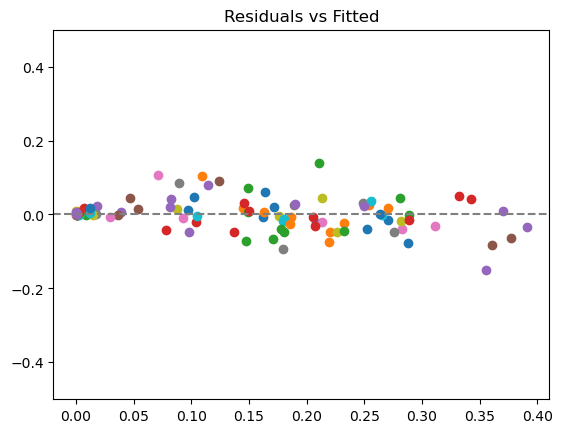

Average abs. residual:  0.028761619338462146


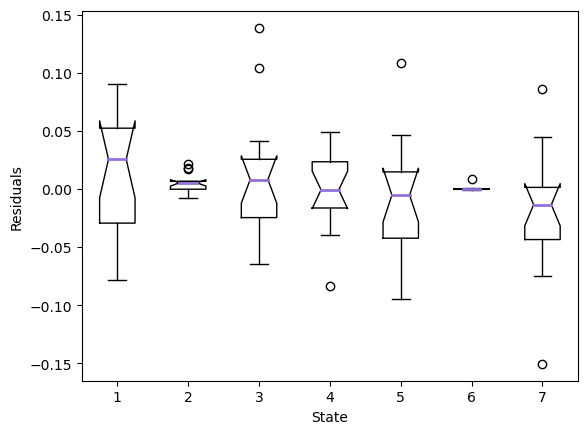

In [10]:
u = u_donors['CVx10']
T = T_donors['CVx10']

# residuals
new = theta_allP
S1_Q = theta_to_Q(new, k, Q_template)

epsi = np.zeros((T-1,k))
pred = np.zeros((k,T))

for i in range(1,T):
    S1_P = transMat(S1_Q, u[i-1])
    pred[:,(i-1)] = np.matmul(S1_P.transpose(),N[:,(i-1)]) 
    epsi[(i-1),:] = N[:,i] - pred[:,(i-1)]
    plt.scatter(pred[:,(i-1)], epsi[(i-1),:])

plt.axhline(y=0, linestyle = '--', color = 'grey')
plt.ylim(-.5,.5)
plt.title("Residuals vs Fitted")
plt.show() 
        
print("Average abs. residual: ", np.mean(abs(epsi)))

plt.boxplot(epsi,
            notch=True,
            medianprops=dict(color="mediumpurple", linewidth=2))
plt.xlabel("State")
plt.ylabel("Residuals")
plt.show()

In [11]:
# transform residual vector
Y = np.array([])
X = np.empty(0)

for t in range(1,T-1):
    Y = np.append(Y,epsi[t,:], axis=0)

    features = epsi[t-1,:]
    X = np.append(X,features, axis = 0)

df=pd.DataFrame(X, columns=['Residual_tm1'])
df = pd.get_dummies(data=df, drop_first=True)
X = df

In [12]:
X = sm.add_constant(X)
X = X.astype('float')
ls=sm.OLS(Y,X).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     4.827
Date:                Tue, 25 Mar 2025   Prob (F-statistic):             0.0304
Time:                        12:50:15   Log-Likelihood:                 171.32
No. Observations:                  98   AIC:                            -338.6
Df Residuals:                      96   BIC:                            -333.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.998e-05      0.004      0.005   

In [13]:
# number of bootstrap samples
B = 1500
startIteration = 676

In [14]:
mcArgs = {'mciter': mc_iter, 'n_cores': numCores}
optimiserArgs = {'costFunc': calc_cost_donors, 'args': (pi_hat_donors, T_donors, k, u_donors, Q_template),'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': theta_initial_ub} 
options = {'xterm': xterm, 'max_iter': max_iter}

In [15]:
 # load old check point into new checkpoint
theta_boot = np.zeros((B,n_param))
checkpoint_filename = "csrResults/CSR_BScheckpoint_theta_boot.pkl"
with open(checkpoint_filename, 'rb') as f:
    theta_boot = pickle.load(f)
    
with open(checkpoint_filename, 'wb') as f:
    pickle.dump(theta_boot,f)

In [16]:
# create new checkpoint array
#theta_boot = np.zeros((B,n_param))
#checkpoint_filename = "csrResults/CSR_BScheckpoint_theta_boot.pkl"
#with open(checkpoint_filename, 'wb') as f:
#    pickle.dump(theta_boot,f)

In [ ]:
residResamp = bootstrap_resResamp_perDonor(point_estimate=theta_allP, 
                             n_bootstrapSamples=B, 
                             n_param=n_param, 
                             theta_generator=make_theta0, 
                             mcArgs=mcArgs, 
                             optimiserArgs=optimiserArgs, 
                             options=options, 
                             checkpoint_filename=checkpoint_filename,
                             startIteration=startIteration)

  0% (0 of 824) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


  0% (1 of 824) |                | Elapsed Time: 2:43:12 ETA:  93 days, 6:43:15
  0% (2 of 824) |              | Elapsed Time: 6:49:27 ETA:  140 days, 13:31:48
  0% (3 of 824) |               | Elapsed Time: 7:27:07 ETA:  21 days, 11:30:13
  0% (4 of 824) |                | Elapsed Time: 8:32:10 ETA:  37 days, 1:03:01
  0% (5 of 824) |                | Elapsed Time: 9:35:32 ETA:  36 days, 0:47:47
  0% (6 of 824) |              | Elapsed Time: 10:50:22 ETA:  42 days, 12:12:33
  0% (7 of 824) |               | Elapsed Time: 12:43:23 ETA:  64 days, 3:04:02
  0% (8 of 824) |               | Elapsed Time: 13:26:03 ETA:  24 days, 4:08:11
  1% (9 of 824) |              | Elapsed Time: 14:21:54 ETA:  31 days, 14:48:14
  1% (10 of 824) |              | Elapsed Time: 15:52:29 ETA:  51 days, 4:51:51
  1% (11 of 824) |             | Elapsed Time: 17:34:37 ETA:  57 days, 15:51:38
  1% (12 of 824) |            | Elapsed Time: 20:45:33 ETA:  107 days, 16:02:29
  1% (13 of 824) |              | Elapse

In [ ]:
filename = "manuscript_results/cVax_bootie_residResamp.pkl"
with open(filename, 'wb') as f:
    pickle.dump(residResamp, f)